## Importing Libraries

In [1]:
#Import Libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
#Configure API
quandl.ApiConfig.api_key = 'yQkk4FX4TYMLj8hg7td9'

In [3]:
#US Energy Information Administration Data
data = quandl.get('EIA/AEO_2016_REF_NO_CPP_PRCE_NA_COMM_NA_ELC_NA_WECCRKS_NCNTPKWH_A')

In [4]:
data.head(5)

,Value
Date,
2014-12-31,10.051101
2015-12-31,9.259127
2016-12-31,9.444813
2017-12-31,9.557723
2018-12-31,9.977324


In [5]:
data.shape

(27, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

In [8]:
#Plot Data
plt.figure(figsize=(15,5), dpi=100)

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

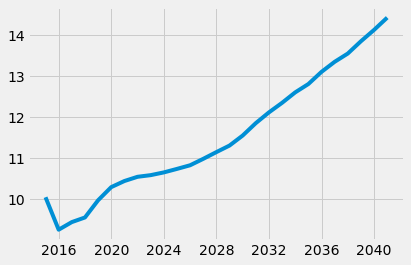

In [9]:
plt.plot(data)

## Subsetting, wrangling, and cleaning

In [10]:
#reset index to use 'date' column
data_2 = data.reset_index()

In [11]:
data_2.head()

,Date,Value
0,2014-12-31,10.051101
1,2015-12-31,9.259127
2,2016-12-31,9.444813
3,2017-12-31,9.557723
4,2018-12-31,9.977324


In [12]:
data_sub = data_2.loc[(data_2['Date'] >= '2014-01-01') & (data_2['Date'] < '2021-12-01')]

In [13]:
data_sub.shape

(7, 2)

In [14]:
data_sub.head()

,Date,Value
0,2014-12-31,10.051101
1,2015-12-31,9.259127
2,2016-12-31,9.444813
3,2017-12-31,9.557723
4,2018-12-31,9.977324


In [15]:
#Set date column as index
data_sub['datetime'] = pd.to_datetime(data_sub['Date']) 
data_sub = data_sub.set_index('datetime') 
data_sub.drop(['Date'], axis=1, inplace=True) 
data_sub.head()

,Value
datetime,
2014-12-31,10.051101
2015-12-31,9.259127
2016-12-31,9.444813
2017-12-31,9.557723
2018-12-31,9.977324


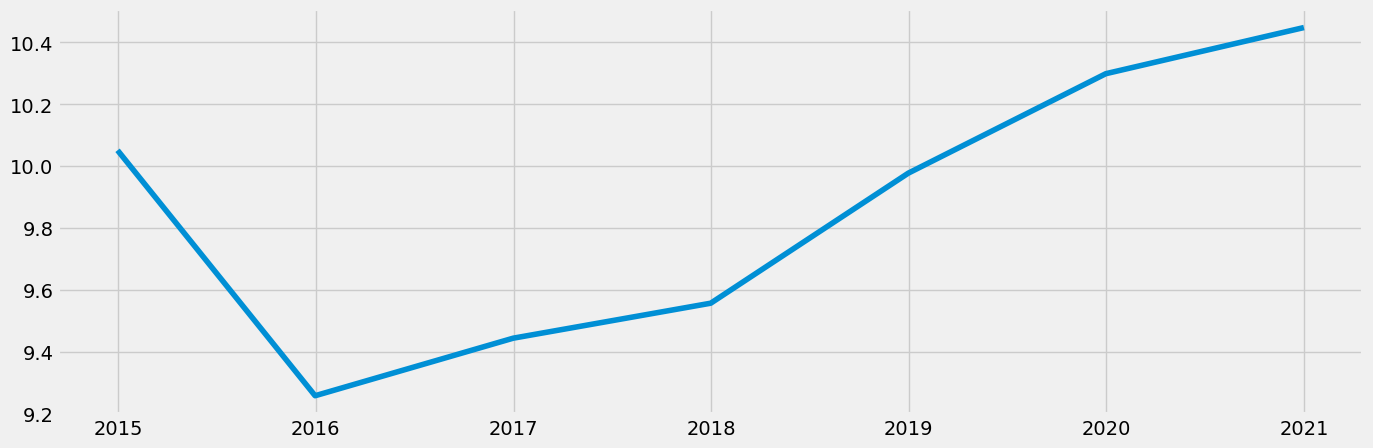

In [16]:
#plot new data
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [17]:
#Check for missing values
data_sub.isnull().sum() 

Value    0
dtype: int64

In [18]:
#Check for duplicates
dups = data_sub.duplicated()
dups.sum()

0

No Duplicates

The logic following the subset values is just using the mose recent dataset. Since the data seems to start around 2014, the data uses the earliest records with the most recent date, zooming in on the data itself.

## Decomposition

In [19]:
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [20]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

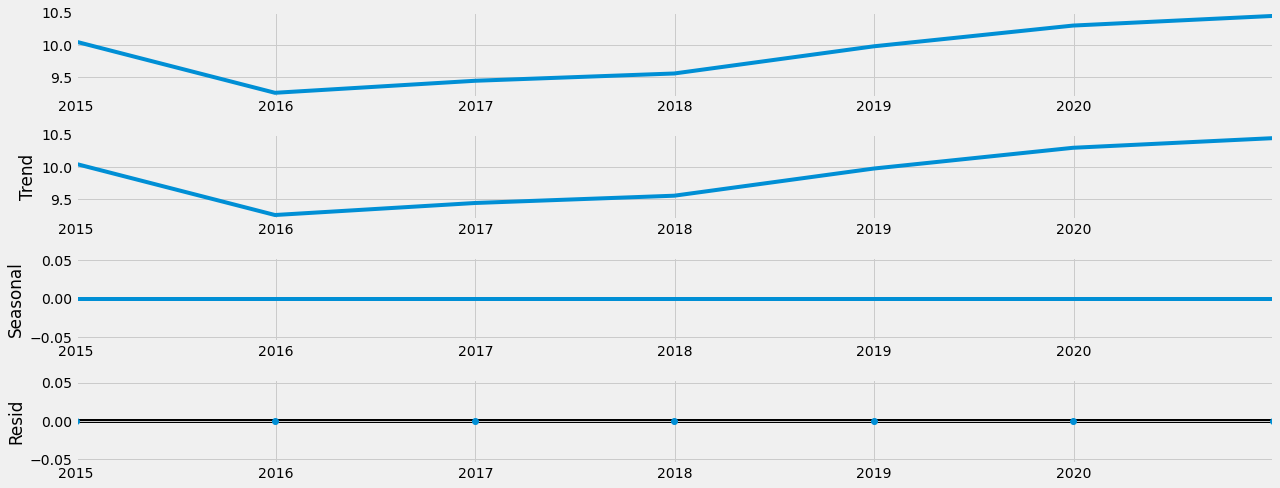

In [21]:
decomposition.plot()
plt.show()

The trend seems to be linear with the original line while the seasonality remains the same throughout. This could be because the natural gas in the west is always distributed evenly.

## Testing for Stationary

In [22]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)
    
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                -0.715651
p-value                        0.842654
Number of Lags Used            0.000000
Number of Observations Used    6.000000
Critical Value (1%)           -5.354256
Critical Value (5%)           -3.646238
Critical Value (10%)          -2.901198
dtype: float64


In this test, the p-value is not less than 0.05 so we cannot reject the null hypothesis. We will try the differencing to get the results.

In [23]:
data_diff = data - data.shift(1)

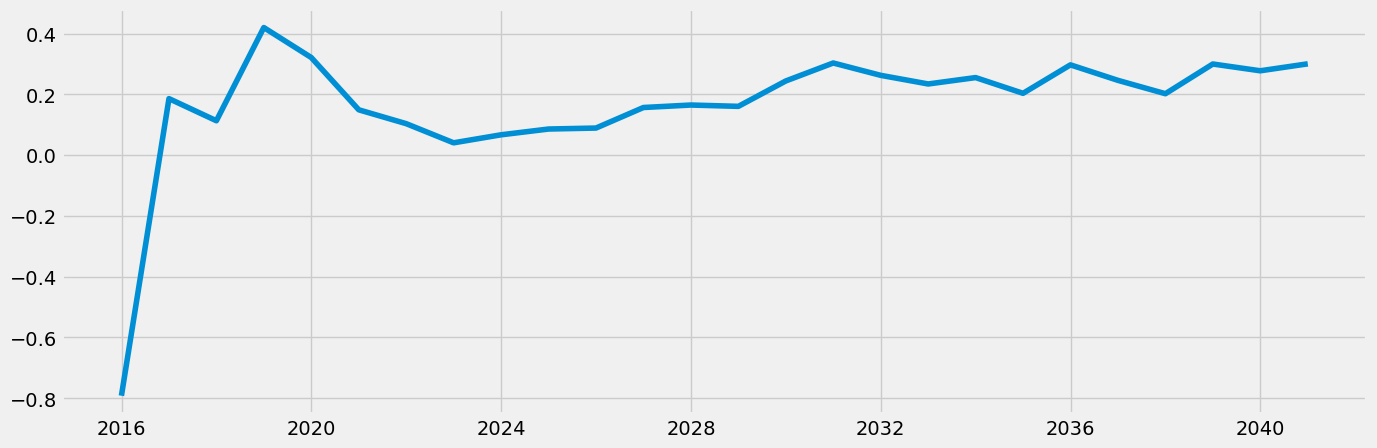

In [24]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [26]:
data_diff.isnull().sum() 

Value    1
dtype: int64

In [27]:
data_diff=data_diff.dropna()

In [28]:
data_diff.isnull().sum() 

Value    0
dtype: int64

In [29]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

dickey_fuller(data_diff['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                -1.025397e+01
p-value                        4.410509e-18
Number of Lags Used            0.000000e+00
Number of Observations Used    2.500000e+01
Critical Value (1%)           -3.723863e+00
Critical Value (5%)           -2.986489e+00
Critical Value (10%)          -2.632800e+00
dtype: float64


Now we have the p-value less than 0.05 we can reject the null hypothesis and the data is stationary.

## Autocorrelations

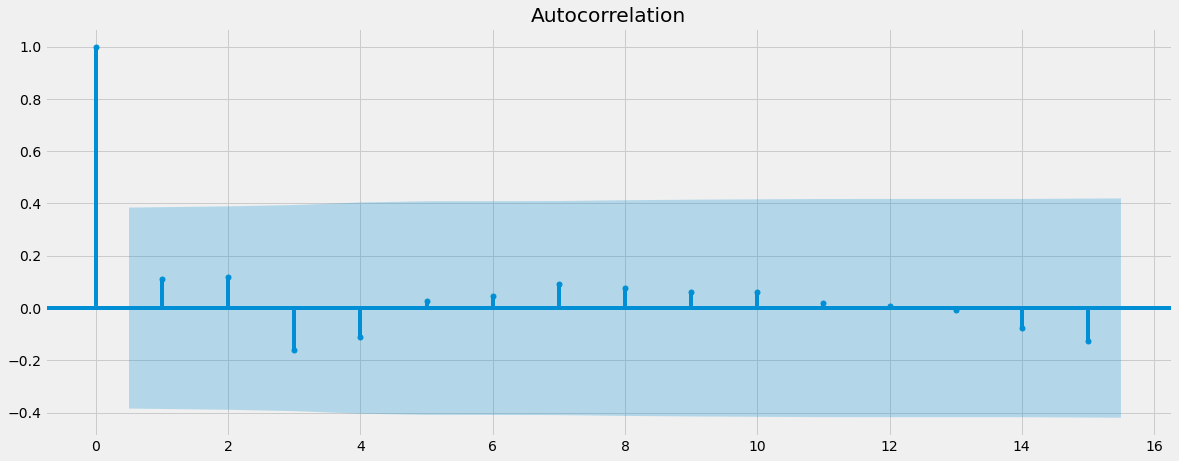

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_diff)
plt.show()